## Setup

In [12]:
import pandas as pd
import numpy as np

import textstat
from scipy.stats import spearmanr, pearsonr, norm
from statsmodels.api import OLS
import statsmodels.api as sm

from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

sns.set_theme()
pd.set_option('display.max_colwidth', None)

data_dir = 'resources/data/'

packages = pd.read_csv(data_dir + 'packages.csv')
packages.dropna(inplace=True, subset=['headline'])
packages['click_rate'] = packages['clicks'] / packages['impressions']
packages.reset_index(inplace=True)

[nltk_data] Downloading package punkt to /home/zmjm/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zmjm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/zmjm/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Pairwise t-statistics

The response of users depends on many factors, including the headline, the image, the time of day, the day of week, the user's mood, etc. The response is binary and stochastic, so we can model it as a Bernoulli random variable $X$ such that $X=1$ denotes that the user decides to click and $X=0$ is not to click.

To model the behavior of a group of users exposed to the same package, we can make the following assumptions:
- Each user make choice of whether to click on a headline independently
- The probability of clicking on a headline is the same for all users

The first assumption is reasonable because the users are typically independent of each other. The second assumption is not very realistic since each user should have his/her own preferences, but it is a good approximation if the number of users for the package is large.

Then the number of clicks $Y = X_1 + X_2 + ... + X_n $ out of $n$ users is a binomial random variable with parameters $n$ and $p$, where $p$ is the probability of clicking on a headline.
In practice, since the click rate is usually small, we can use a Poisson distribution to approximate the binomial distribution, therefore the variance of $Y$ is $np$ which is the same as the expected value.

From the observed $Y$, we can estimate the click rate $p$ as $\hat{p} = Y/n$ and the variance of the estimate is $\hat{p}/n$.
The t-statistic of the difference in click rate between two packages is then
$$ t = \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{\hat{p}_1/n_1 + \hat{p}_2/n_2}} $$
where $n_1$ and $n_2$ are the number of users exposed to the two packages respectively.

Since the number of packages within a test could be more than 2, we define the pairwise t-statistic of a test as the t-statistic of the difference in click rate between two packages within the test. Then we can perform a t-test on the pairwise t-statistics to determine whether the difference in click rate between two packages is statistically significant.

Additionally, since we want to study the effect of headline, we can look into the pair of packages that are different only by their headlines.

In [4]:
tests = packages.groupby('test_id', group_keys=False)
t_stat = pd.DataFrame(columns=['test_id', 'A_package_id', 'B_package_id', 'A_headline', 'B_headline', 't', 'A_click_rate', 'B_click_rate', 'A_impressions', 'B_impressions'])

for test_id, test in tqdm(tests):
    if len(test) >= 2:
        num_packages = len(test)
        
        for i in range(num_packages - 1):
            for j in range(i + 1, num_packages):

                test_a, test_b = test.iloc[i], test.iloc[j]
                
                if test_a.click_rate == 0 and test_b.click_rate == 0:
                    continue

                if test_a.headline == test_b.headline:
                    continue

                if test_a.image_id != test_b.image_id:
                    continue
                
                t = (test_a.click_rate - test_b.click_rate) / np.sqrt(
                    test_a.click_rate/test_a.impressions + test_b.click_rate/test_b.impressions)
                
                if t > 0:
                    t_stat.loc[len(t_stat)] = [test_id, test.index[i], test.index[j], test_a.headline.lower(), test_b.headline.lower(), 
                                               t, test_a.click_rate, test_b.click_rate, test_a.impressions, test_b.impressions]
                else:
                    t_stat.loc[len(t_stat)] = [test_id, test.index[j], test.index[i], test_b.headline.lower(), test_a.headline.lower(), 
                                               t, test_b.click_rate, test_a.click_rate, test_b.impressions, test_a.impressions]

100%|██████████| 32487/32487 [10:18<00:00, 52.53it/s] 


In [42]:
t_stat.t.describe()

count    140621.000000
mean          0.168743
std           1.967454
min         -13.314745
25%          -1.053958
50%           0.185051
75%           1.387549
max          14.248627
Name: t, dtype: float64

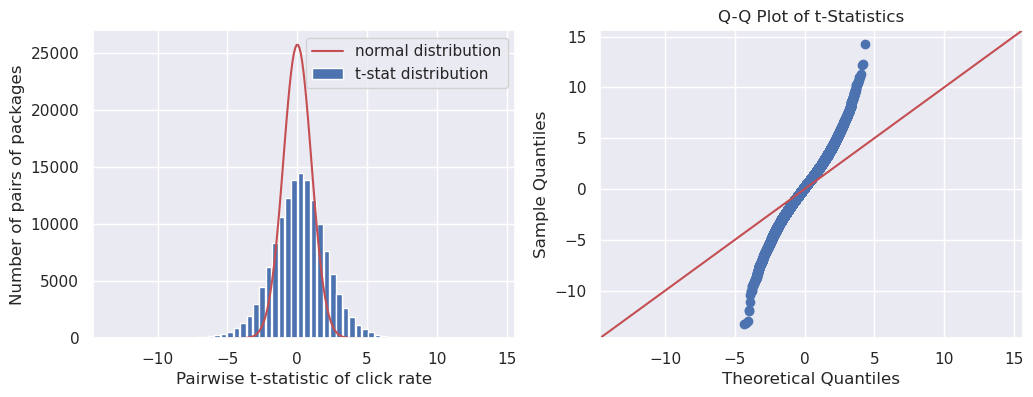

In [53]:
count, binedge = np.histogram(t_stat.t, bins=60)
bincenter = (binedge[:-1] + binedge[1:]) / 2

excess = count / norm.pdf(bincenter)

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.bar(bincenter, count, width=0.4, label='t-stat distribution')
plt.plot(np.linspace(-5, 5, 100), norm.pdf(np.linspace(-5, 5, 100), 0, 1) * len(t_stat) * (binedge[1] - binedge[0]), 'r', label='normal distribution')
plt.legend()
plt.xlabel('Pairwise t-statistic of click rate')
plt.ylabel('Number of pairs of packages')

sm.qqplot(t_stat.t, line='45', ax=plt.subplot(122))
plt.title('Q-Q Plot of t-Statistics')
plt.show()

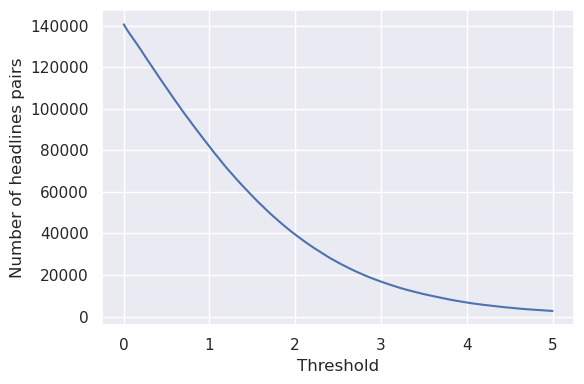

In [73]:
thresholds = np.linspace(0, 5, 100)
size = []

for threshold in thresholds:
    size.append(sum(abs(t_stat.t) > threshold))

plt.figure(figsize=(6, 4))
plt.plot(thresholds, size)
plt.xlabel('Threshold')
plt.ylabel('Number of headlines pairs')
plt.tight_layout()
plt.show()

## Language complexity measure

- Type-token ratio: https://en.wikipedia.org/wiki/Lexical_diversity#Type%E2%80%93token_ratio
- Flesch-Kincaid Grade Level: https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests#Flesch%E2%80%93Kincaid_grade_level
- Word complexity: https://en.wikipedia.org/wiki/Lexical_density

### Type-token ratio

In [110]:
def get_TTR(texts):
    vocab = dict()
    tokens = 0
    ttr = []

    for text in tqdm(texts):
        words = word_tokenize(text)
        for word in words:
            if word not in vocab:
                vocab[word] = 1
            else:
                vocab[word] += 1
            tokens += 1
            ttr.append(len(vocab) / tokens)
        
    return ttr, vocab, tokens

def split_headlines(t_stat, threshold):
    good_headlines = t_stat.A_headline[abs(t_stat.t) > threshold]
    bad_headlines = t_stat.B_headline[abs(t_stat.t) > threshold]

    good_headlines = good_headlines.sample(frac=1, random_state=0)
    bad_headlines = bad_headlines.sample(frac=1, random_state=0)

    mixed_headlines = pd.concat([good_headlines, bad_headlines], ignore_index=True).sample(frac=1, random_state=0)

    good_headlines_unique = good_headlines.unique()
    bad_headlines_unique = bad_headlines.unique()

    print('good_headlines: {}, bad_headlines: {}, good_headlines_unique: {}, bad_headlines_unique: {}'.format(
        good_headlines.shape[0], bad_headlines.shape[0], good_headlines_unique.shape[0], bad_headlines_unique.shape[0]))
    
    return {'good': good_headlines, 'bad': bad_headlines, 'good_unique': good_headlines_unique, 'bad_unique': bad_headlines_unique, 'mixed': mixed_headlines}

In [111]:
thresholds = [0, 1, 2, 3, 4, 5]

ttr = dict()
vocab = dict()
tokens = dict()

for i, threshold in enumerate(thresholds):
    corpus = split_headlines(t_stat, threshold=threshold)
    ttr[threshold] = dict()
    vocab[threshold] = dict()
    tokens[threshold] = dict()

    for text in ['good', 'bad', 'good_unique', 'bad_unique', 'mixed']:
        ttr[threshold][text], vocab[threshold][text], tokens[threshold][text] = get_TTR(corpus[text])

good_headlines: 140594, bad_headlines: 140594, good_headlines_unique: 48715, bad_headlines_unique: 53683


100%|██████████| 281188/281188 [00:18<00:00, 15177.18it/s]


good_headlines: 81791, bad_headlines: 81791, good_headlines_unique: 34402, bad_headlines_unique: 39827


100%|██████████| 163582/163582 [00:11<00:00, 14679.03it/s]


good_headlines: 39455, bad_headlines: 39455, good_headlines_unique: 19741, bad_headlines_unique: 23482


100%|██████████| 78910/78910 [00:05<00:00, 15158.18it/s]


good_headlines: 16808, bad_headlines: 16808, good_headlines_unique: 9595, bad_headlines_unique: 11532


100%|██████████| 33616/33616 [00:02<00:00, 15256.47it/s]


good_headlines: 6757, bad_headlines: 6757, good_headlines_unique: 4214, bad_headlines_unique: 5103


100%|██████████| 13514/13514 [00:00<00:00, 15316.80it/s]


good_headlines: 2701, bad_headlines: 2701, good_headlines_unique: 1812, bad_headlines_unique: 2178


100%|██████████| 5402/5402 [00:00<00:00, 15442.46it/s]


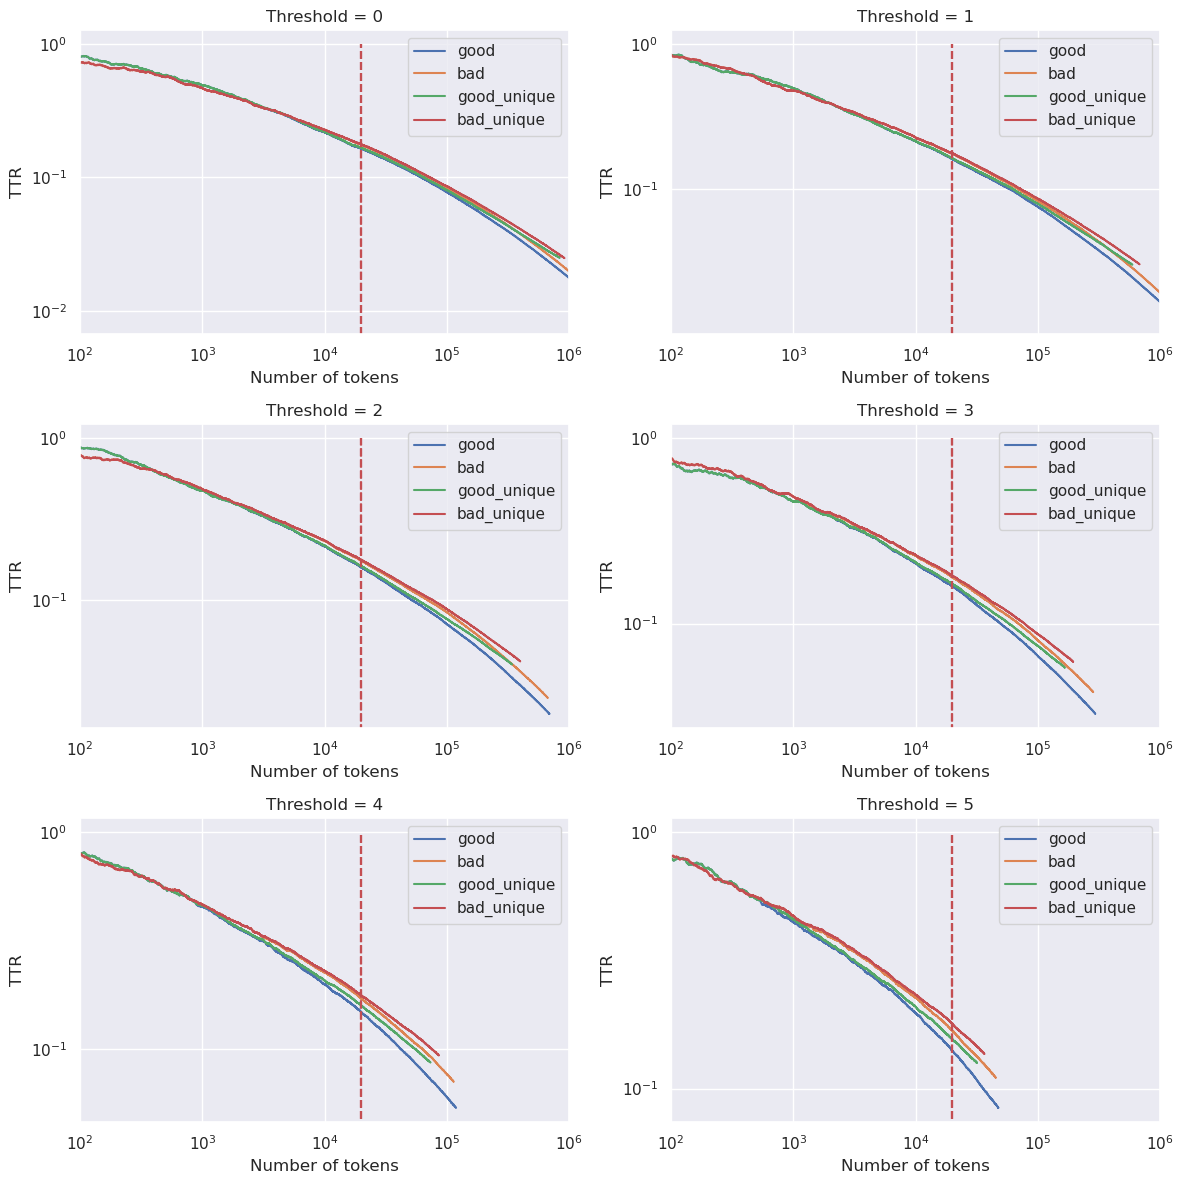

In [112]:
plt.figure(figsize=(12, 12))

for i, threshold in enumerate(thresholds):
    plt.subplot(3, 2, i + 1)
    plt.plot(ttr[threshold]['good'], label='good')
    plt.vlines(2e4, 0, 1, linestyles='dashed', colors='r')
    plt.plot(ttr[threshold]['bad'], label='bad')
    plt.vlines(2e4, 0, 1, linestyles='dashed', colors='r')
    plt.plot(ttr[threshold]['good_unique'], label='good_unique')
    plt.vlines(2e4, 0, 1, linestyles='dashed', colors='r')
    plt.plot(ttr[threshold]['bad_unique'], label='bad_unique')
    plt.vlines(2e4, 0, 1, linestyles='dashed', colors='r')
    plt.xlim(1e2, 1e6)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.xlabel('Number of tokens')
    plt.ylabel('TTR')
    plt.title('Threshold = {}'.format(threshold))

plt.tight_layout()
plt.show()

In [113]:
num_tokens = 2e4

ttr_record = dict()
for i, threshold in enumerate(thresholds):
    ttr_record[threshold] = dict()
    for text in ['good', 'bad', 'good_unique', 'bad_unique', 'mixed']:
        ttr_record[threshold][text] = ttr[threshold][text][int(num_tokens)]

ttr_record = pd.DataFrame(ttr_record).T
ttr_record

,good,bad,good_unique,bad_unique,mixed
0,0.163942,0.175591,0.166642,0.176841,0.172441
1,0.160642,0.174141,0.162342,0.175741,0.167642
2,0.159542,0.175241,0.162092,0.176841,0.168442
3,0.158892,0.177091,0.163742,0.180591,0.166092
4,0.147643,0.170641,0.158542,0.176291,0.163242
5,0.140243,0.168042,0.155642,0.178941,0.160642


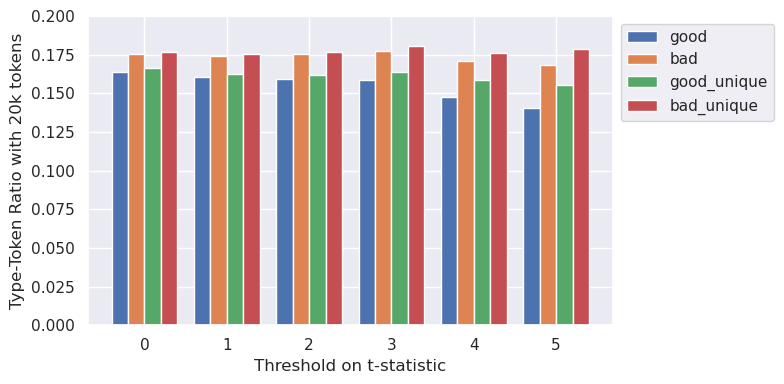

In [117]:
plt.figure(figsize=(8, 4))

indices = np.arange(len(ttr_record['good']))

plt.bar(indices - 0.3, ttr_record['good'], width=0.2, label='good')
plt.bar(indices - 0.1, ttr_record['bad'], width=0.2, label='bad')
plt.bar(indices + 0.1, ttr_record['good_unique'], width=0.2, label='good_unique')
plt.bar(indices + 0.3, ttr_record['bad_unique'], width=0.2, label='bad_unique')
# plt.bar(indices + 0.5, ttr_record['mixed'], width=0.2, label='mixed')

# move the legend to the upper left corner
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Threshold on t-statistic')
plt.ylabel('Type-Token Ratio with 20k tokens')
plt.ylim(0, 0.2)
plt.tight_layout()
plt.show()